<a id="top"></a>
# Easy IMA Viewer


***
## Learning Goals

This notebook is intended to be a resouce for newer users of WFC3/IR data. 

- Learn about the IMA file type.
- Download an IMA from MAST.
- Visualize the different reads of the IMA.
- Save the plotted reads as individual images, an animated GIF, or both.

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Display IMA files](#display) <br>
- [2.1 Data](#data) <br>
- [2.2 Create IMA viewer](#create) <br>
- [2.3 Save files](#save) <br>

[3. Conclusions](#conclusions) <br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>

<a id="intro"></a>
## Introduction 

The WFC3 calibration pipline (calwf3) produces many different types of FITS files for each observation. 
The **intermediate MultiAccum** (IMA) file type is unique to the IR detector, and it is produced after all calibrations are applied (dark subtraction, linearity correction, flat fielding, etc.) to each of the individual readouts of the IR dataset. 
Since the reads are kept in separate extensions of the IMA, it is possible to see how the observation developed over exposure time, thus making it a valuable resource especially in cases of image anomalies, potential guide star failures, satellite trails, etc. 
However, IMA files can be confusing to inspect, largely due to the order of the FITS extensions and the possible extension types.

This notebook leverages a set of functions, imported as a package, that allow for interactive visualization of an IMA file through Jupyter Widgets. You will be able to easily plot, customize, and save both static plots and animated GIFs (Graphics Interchange Format). 

<a id="imports"></a>
## 1. Imports

Please see the `README.md` file for package specifications and instructions for creating a virtual environment.

This notebook uses the following libraries:
- *astropy.io fits* for accessing FITS files
- *astroquery.mast Observations* for downloading data from MAST
- *imageio* to make and save animated GIFs
- *ipympl* as a matplotlib backend to enable interactive widgets
- *IPython.display* to display widgets and other components
- *ipywidgets* to make widgets for plotting
- *matplotlib pyplot* for plotting data
- *matplotlib.ticker* to configure tick locating and formatting 
- *matplotlib.colors* to normalize images
- *numpy* for calculating limit percentiles
- *os* for verifying and creating paths
- *shutil* for moving files

In [1]:
from astropy.io import fits
from astroquery.mast import Observations
import imageio.v2 as imageio
from IPython.display import display
from ipywidgets import interact, interactive, Layout
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib.colors import Normalize
import numpy as np
import os
import shutil
%matplotlib ipympl

from ima_tools import make_interactive_plot, gif_settings_widgets, make_frames, make_gif

<a id="display"></a>
## 2. Display IMA files 

In this section, we will download an IMA file (if needed), create an interactive plot of the IMA file, and then save the output as frames and a composite animated GIF. 

<a id="data"></a>
### 2.1 Data

If you already have an IMA file you'd like to visualize, you can define the path to the file in the cell below.

In [2]:
#filepath = path/to/file_ima.fits

If you've defined a path in the cell above, you can now skip to the next subsection. 

Otherwise, continue on to download a file from MAST.

Let's download the IMA for a particular observation, which has a rootname or observation ID of `idpq32w0q`. 

Importantly, even if we know the observation ID, if the particular observation is part of an association, the `query_criteria` function will not be able to find the exact observation.  

In [3]:
obs_id = 'idpq32w0q'

obs = Observations.query_criteria(obs_id=obs_id)
print(len(obs))

0


Instead, we can use the first six characters, which uniquely represent the instrument identifier, program ID, and the visit number. To that, we add a wildcard character so that we get a list of observations from the same instrument, program, and visit as our intended observation, `idpq32w0q`.

You can read more about the HST file naming conventions [here](https://archive.stsci.edu/hlsp/ipppssoot.html). 

In [4]:
obs = Observations.query_criteria(obs_id=obs_id[:6]+'*')
print(len(obs))

3


Now we can access the products for these three observations in the same visit. We'll nest a couple of functions here, but [read the documentation](https://astroquery.readthedocs.io/en/latest/mast/mast.html) if you'd like to learn more about the `astroquery.mast` library. 

For this step, we set `productSubGroupDescription` to only return to us IMA files. Also in this step, we can precisely specify our observation ID. 

In [5]:
prods = Observations.filter_products(Observations.get_product_list(obs),
                                     productSubGroupDescription='IMA',
                                     obs_id='idpq32w0q')
prods

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str35,str62,str1,str67,str9,str28,str11,str1,str6,str19,str5,str50,int64,str8,str6,int64
26190073,HST,image,idpq32w0q,DADS IMA file - Intermediate Mult-Accum WFC3/NICMOS,S,mast:HST/product/idpq32w0q_ima.fits,AUXILIARY,--,IMA,--,CALWF3,3.6.2 (May-27-2021),15363,idpq32w0q_ima.fits,126201600,26190085,PUBLIC,2


We'll now be able to download our file to the current working directory. 

In [6]:
downloads = Observations.download_products(prods)
downloads

Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/idpq32w0q/idpq32w0q_ima.fits,COMPLETE,None,None


The subdirectories made as part of this step are a bit cumbersome when we only have one file, so let's clean it up. 

In [7]:
downloaded_location = downloads['Local Path'][0]

# move file to current working directory
new_location = shutil.move(downloaded_location, os.getcwd())

# now that there aren't any files, we can remove the default mastDownload directory
shutil.rmtree('mastDownload')

# set filepath variable 
filepath = f'{obs_id}_ima.fits'

# double-check that the file was successfully moved
os.path.exists(filepath)

True

Now we're ready to visualize. 

<a id="create"></a>
### 2.2 Create IMA viewer

Running the cell below will create a simple, interactive viewer so that you can inspect your IMA. 

- Using the controls at the top, you can scrub through the different extensions in chronological order, change the colormap, and adjust the scaling percentiles. 

- The default extension type is "SCI" for science. To view the error extensions, set `ext_type` to "ERR". To view the data quality flags extensions, set `ext_type` to "DQ". 

- As you pan your cursor over the plot, the pixel location (in x and y coordinates) and value update at the bottom.

- You can use the plotting controls on the left to pan and zoom, as well as to save the current plot as a static image.

There is an abrupt change within this exposure. See if you can figure out what it is.

interactive(children=(Dropdown(description='Colormap: ', index=86, layout=Layout(width='50%'), options=('magma…

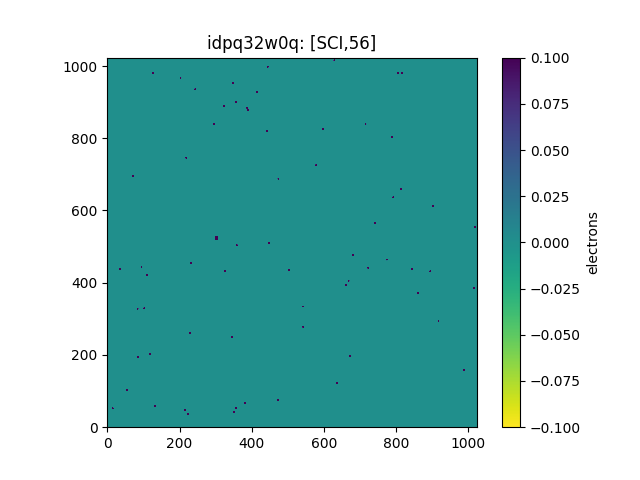

In [9]:
plot = make_interactive_plot(filepath, ext_type='SCI')

<a id="save"></a>
### 2.3 Save files

Running the cell below will generate options for saving your IMA as frames, a GIF, or both. The limits, colormap, scaling, etc. will reflect whatever is currently set above. 

In [11]:
gif_setup = gif_settings_widgets(plot)

When the IMA viewer and the widget settings are to your liking, run the following two cells to 
1. Make the frames. 
2. Make the gif. 

In [14]:
gif_frames = make_frames(plot, gif_setup)

Writing to directory: idpq32w0q_0-1023_0-1023
Will not overwrite any existing files.


In [15]:
make_gif(gif_frames, gif_setup)

GIF saved.


<a id="conclusions"></a>
## 3. Conclusions 

Thank you for walking through this notebook! You have:
- learned about the format and purpose of IMA files
- examined different reads of an IMA file
- created image frames and/or GIFs for a particular customized view.  

**Congratulations, you have completed the notebook.**

<a id="add"></a>
## Additional Resources 

Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [Types of WFC3 Files](https://hst-docs.stsci.edu/wfc3dhb/chapter-2-wfc3-data-structure/2-1-types-of-wfc3-files)


<a id="about"></a>
## About this Notebook 

**Author:** Mariarosa Marinelli, ISSB/WFC3

**Updated On:** 2022-12-19

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 